# Solver - Tutorial

## Non colliding fiber models

An important component of nerve fibers is that they are 3d objects.
Therefore, they should not overlap each other.
To achieve this, an [algorithm](https://arxiv.org/abs/1901.10284) was developed based on collision checking of conical objects.
A conical object is defined by two  neighboring points in the fiber array, i.e. fiber[i] and fiber[i+1].

The class `solver` checks a given fiber model for collisions and resolves these collisions iteratively by small displacements.

To account for the flexibility of fibers, they are continuously divided into segments. These segments are modeled geometrically as cones.

A parallel implementation of an octree is used to run the collision detection algorithm between these cones.

## General imports

First, we prepair all necesarry modules and defining a function to euqalice all three axis of an 3d plot.

In [2]:
import fastpli.model.solver
import fastpli.model.sandbox
import fastpli.io


import os

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

def set_3d_axes_equal(ax):
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    plot_radius = 0.5 * max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

def plot_fiber_bundles(fbs, colors):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    for fb, c in zip(fbs, colors):
        for f in fb:
            plt.plot(f[:,0],f[:,1],f[:,2], c)
    set_3d_axes_equal(ax)

## Prepairing Models and defining bounding conditions

The [fiber bundles](https://github.com/3d-pli/fastpli/wiki/FiberBundles) are prepaired as shown in the sandbox examples/tutorials.
Additionally each fiber will get a random radius.

Two crossing fiber bundle (x and y) are prepaiered in this manor.

### Note
- Take note that matplotlib does not check z-buffering. Therefore each new plotted line is on top of the lines before.
That why the second fiber bundle (red) seems to be on top of the first one (blue).

- Also not be showing here.
The solver class provides an OpenGL visualization tool `solver.draw_scene()` which is not shown in this notebook since.
The example file `examples/solver.py` and [wiki](https://github.com/3d-pli/fastpli/wiki/Solver) shows its capabilities.



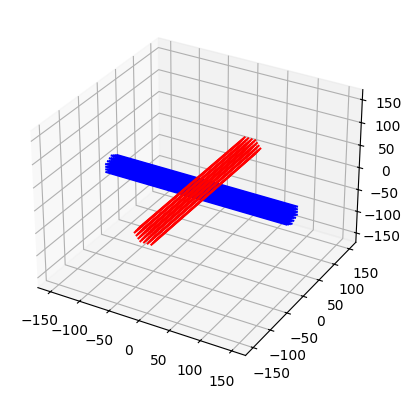

In [36]:
solver = fastpli.model.solver.Solver()

fiber_bundle_trj_x = [[-150, 0, 0], [150, 0, 0]]
fiber_bundle_trj_y = [[0, -150, 0], [0, 150, 0]]

population = fastpli.model.sandbox.seeds.triangular_circle(20, 6)

fiber_radii = np.random.uniform(2.0, 10.0, population.shape[0])
fiber_bundle_x = fastpli.model.sandbox.build.bundle(fiber_bundle_trj_x,
                                                    population, fiber_radii)

fiber_radii = np.random.uniform(2.0, 10.0, population.shape[0])
fiber_bundle_y = fastpli.model.sandbox.build.bundle(fiber_bundle_trj_y,
                                                    population, fiber_radii)

fiber_bundles = [fiber_bundle_x, fiber_bundle_y]

plot_fiber_bundles(fiber_bundles, ['b', 'r'])
plt.show()

## Running solver

The solver algorithm splits each fiber into almost equal fiber segments allowing to seperate the model more naturally.
The mean length of this segments is controlled via `solver.obj_mean_length`.
Since the fiber segments will move in each step of the algorithm, the curviture of the fibers can increase quite fast.
To limit this a maximal curviture radii of the fibers can be set via `solver.obj_min_radius`.
This means that a "circle" of point `p_i-1, p_i` and `p_i+1` is limited by a lower value.
Is the value exceeded, the betroffende fiber segments are corrected slightly.

If all conditions are fullfiled, the output is marked as solved and the model can be used for further processing.

solved: 705, 777/0


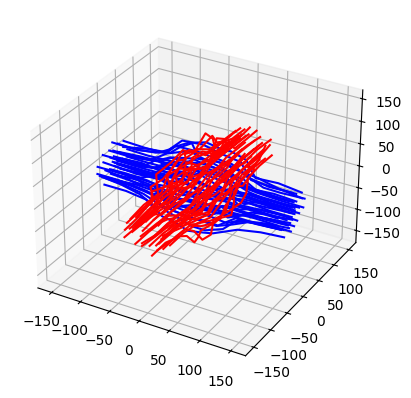

In [37]:
# run solver
solver.fiber_bundles = fiber_bundles
solver.obj_min_radius = 10
solver.obj_mean_length = 30

N = 1000
for i in range(N):
    solved = solver.step()
    if solved:
        break
    print(f'{i/N*100:.2f}%', end='\r')
print(f'solved: {i}, {solver.num_obj}/{solver.num_col_obj}')

plot_fiber_bundles(solver.fiber_bundles, ['b', 'r'])
plt.show()

## Saving

The resulting configuration can be save in a `.dat` file or `.h5` (HDF5) file wich is supported via this toolbox.

In [53]:
np.array(solver.fiber_bundles)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 37) + inhomogeneous part.

In [17]:
fastpli.io.fiber_bundles.save('output.h5', solver.fiber_bundles, mode='w')

## Funktionen für ODFs etc

In [54]:
import numpy as np
# Vorherige Imports
import math
import time
import matplotlib.pyplot as plt
from colour import Color
from collections import Counter
import random
from time import gmtime, strftime
from numba import jit, njit
import pickle 
import odf2
import h5py

def load_dict(range_r = 6, factor = 10):
    with open(f'cache_dict_range_{range_r}_factor_{factor}.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)
    return loaded_dict


def save_dict(dict_cache={}, range_r = 6, factor = 10):
    with open(f'cache_dict_range_{range_r}_factor_{factor}.pkl', 'wb') as f:
        pickle.dump(dict_cache, f)
    return


def get_array(dict_cache, key):
    return dict_cache[tuple(key)]


def koords_in_kegel_cache(range_r = 4, alpha = np.array([]), beta = np.array([])):
    # Winkel umdrehen, da Koordinatensystem gedreht wird anstatt der Punkte
    cos_alpha = np.cos(-alpha)
    sin_alpha = np.sin(-alpha)
    cos_beta = np.cos(-beta)
    sin_beta = np.sin(-beta)
    cos_alpha_cos_beta = cos_alpha*cos_beta
    sin_alpha_cos_beta = sin_alpha*cos_beta
    cos_alpha_sin_beta = cos_alpha*sin_beta
    sin_alpha_sin_beta = sin_alpha*sin_beta
    
    # erstelle das Gitter für x, y und z
    x = np.linspace(-range_r*2, range_r*2, range_r*4+1)
    y = np.copy(x)
    z = np.copy(x)
    length = int(((2*range_r)**3)/6)+1

    # Erstelle das Gitter für x, y und z
    x_grid, y_grid, z_grid = np.meshgrid(x, y, z)
    # test_x = np.copy(x_grid)
    result = np.empty((len(cos_alpha), 3, length)) * np.nan

    for i, ca, sa, cb, sb, cacb, sacb, casb, sasb in zip(range(len(cos_alpha)), cos_alpha, sin_alpha, cos_beta, sin_beta, cos_alpha_cos_beta, sin_alpha_cos_beta, cos_alpha_sin_beta, sin_alpha_sin_beta):
        # erst x achse dann y achse
        mask = (((ca*y_grid-sa*z_grid)**2 + (cacb*z_grid-sb*x_grid+sacb*y_grid)**2 < (casb*z_grid+sasb*y_grid+cb*x_grid)**2) & (0 < (casb*z_grid+sasb*y_grid+cb*x_grid)) & (range_r > (casb*z_grid+sasb*y_grid+cb*x_grid)))
        # x,y,z werte mit der spezifischen Maske auf die Kegel zuschneiden
        x_mask = x_grid[mask]
        y_mask = y_grid[mask]
        z_mask = z_grid[mask]
        data = np.array([x_mask, y_mask, z_mask])
        result[i,:,:np.shape(data)[1]] = data
    return result


def get_points(range_r):
    # Punkte vordefinieren
    x = np.arange(-range_r, range_r+1, 1)
    y = np.copy(x)
    z = np.copy(x)
    # erstelle das Gitter für x, y und z
    x_grid, y_grid, z_grid = np.meshgrid(x, y, z)
    # Punkte außerhalb des Kegels filtern 
    mask = (x_grid**2 + y_grid**2 + z_grid**2 <= (range_r+1)**2) & (x_grid**2 + y_grid**2 + z_grid**2 >= (range_r-1)**2)
    x_mask = x_grid[mask]
    y_mask = y_grid[mask]
    z_mask = z_grid[mask]
    # x, y, z zusammenfassen
    Kugelschale = np.concatenate((x_mask[:,None], y_mask[:,None], z_mask[:,None]), axis=1)
    # Kugelkoordinaten Winkel bestimmen
    beta = np.arccos(Kugelschale[:,0]/range_r)
    if np.sum(np.isnan(beta)) > 0:
        print(f"Warning, {np.sum(np.isnan(beta))} nan entries in beta!!!")
    alpha = np.arctan2(Kugelschale[:,2],Kugelschale[:,1])+math.pi/2
    if np.sum(np.isnan(alpha)) > 0:
        print(f"Warning, {np.sum(np.isnan(alpha))} nan entries in alpha!!!")
    return(Kugelschale, alpha, beta)


def generate_dict(range_r = 10, factor = 10):
    Kugelschale, alpha, beta = get_points(factor)
    temp_dict = {tuple(a_row): b_row for a_row, b_row in zip(Kugelschale, koords_in_kegel_cache(range_r, alpha, beta))}
    return temp_dict


def kegel_from_dict(dict_cache={}, factor=10, x_koord=0, y_koord=0, z_koord=0, alpha=np.array([]), beta=np.array([]), paralell_bool=False, get_phi_theta = False):
    # Winkelfunktionen vordefinieren
    cos_alpha = np.cos(alpha)
    sin_alpha = np.sin(alpha)
    cos_beta = np.cos(beta)
    sin_beta = np.sin(beta)
    # Karthesische Koordinate der symetrieachse berehnen
    x = (cos_beta)
    y = (sin_alpha*sin_beta)
    z = (-cos_alpha*sin_beta)
    koords = np.concatenate((x,y,z), axis=1)
    koords_rounded_int = np.array(np.round(koords*factor, 0), dtype=int)
    # Daten aus dem Dict herausholen
    if paralell_bool == False:
        arrays = [dict_cache[tuple(key)] for key in koords_rounded_int]
        result = np.array(arrays)
    # else:  # langsamer
    #     result = np.array(Parallel(n_jobs=-1)(delayed(get_array)(dict_cache,key) for key in koords_rounded_int))

    result[:,0,:] += x_koord
    result[:,1,:] += y_koord
    result[:,2,:] += z_koord
    if get_phi_theta == True:
        # Phi und Theta berechnen für ODFs
        phi = np.arccos(z)
        theta = np.arctan2(y,x)
        costheta = np.cos(theta)
        sintheta = np.sin(theta)
        return (result, phi, costheta, sintheta)

    return result


# anpassung der schnellen ungenauen berechnung der Kegel, da die Funktion zur bewertung der Punlte kontinuiertlich ist.
def reverse_rotate_and_translate_data(data, x_koord = 0, y_koord = 0, z_koord = 0, alpha = np.array([]), beta = np.array([])):
    # Translation Rückgängig machen
    data_ = np.copy(data)
    data_[:,0,:] -= x_koord
    data_[:,1,:] -= y_koord
    data_[:,2,:] -= z_koord
    # Für Optimierung Variablen vor definieren
    cos_alpha = np.cos(-alpha)
    sin_alpha = np.sin(-alpha)
    cos_beta = np.cos(-beta)
    sin_beta = np.sin(-beta)
    # Erzeuge Rotationsmatrizen für alle Winkel gleichzeitig
    rotation_matrix = np.empty((len(alpha), 3, 3))
    # Fülle die Rotationsmatrizen für alle Winkel gleichzeitig
    rotation_matrix[:, 0, 0] = cos_beta.ravel()
    rotation_matrix[:, 0, 1] = (sin_alpha*sin_beta).ravel()
    rotation_matrix[:, 0, 2] = (cos_alpha*sin_beta).ravel()

    rotation_matrix[:, 1, 0] = np.zeros_like(cos_beta).ravel()
    rotation_matrix[:, 1, 1] = cos_alpha.ravel()
    rotation_matrix[:, 1, 2] = -sin_alpha.ravel()

    rotation_matrix[:, 2, 0] = -sin_beta.ravel()
    rotation_matrix[:, 2, 1] = (sin_alpha*cos_beta).ravel()
    rotation_matrix[:, 2, 2] = (cos_alpha*cos_beta).ravel()
    # Wende die Rotationsmatrix auf die Daten an
    result = np.matmul(rotation_matrix, data_)
    result[:,0,:] += x_koord
    result[:,1,:] += y_koord
    result[:,2,:] += z_koord
    return result


def get_basis(phi:np.ndarray, costheta:np.ndarray, sintheta:np.ndarray, band:int)->np.ndarray:
    basis = np.empty((phi.shape[0], odf2.get_num_coeff(band)))
    for i, (p, ct, st) in enumerate(zip(phi, costheta, sintheta)):
        basis[i, :] = odf2._analytic_single_odf(ct, st, p, band)
    return basis


# def get_basis(phi:np.ndarray, costheta:np.ndarray, sintheta:np.ndarray, band:int)->np.ndarray:
#     basis = np.empty((phi.shape[0], odf.get_num_coeff(band)))
#     for i, (p, ct, st) in enumerate(zip(phi, costheta, sintheta)):
#         basis[i, :] = odf._analytic_single_odf(ct, st, p, band)
#     return basis


def gauss_3d(x,y,z,mu_x=0,mu_y=0,mu_z=0,sigma=2):
    return 1/(np.sqrt(math.pi*2)*sigma)*np.exp(-1/2*(((x-mu_x)/sigma)**2+((y-mu_y)/sigma)**2+((z-mu_z)/sigma)**2))


def gauss_2d(x,y,mu_x=0,mu_y=0,sigma=2):
    return 1/(np.sqrt(math.pi*2)*sigma)*np.exp(-1/2*(((x-mu_x)/sigma)**2+((y-mu_y)/sigma)**2))


def gauss_1d(x,mu_x=0,sigma=2):
    return 1/(np.sqrt(math.pi*2)*sigma)*np.exp(-1/2*(((x-mu_x)/sigma)**2))


def load_data(start, end):
    for i in range(end-start):
        if i == 0:
            f_mask = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_a00_d000_Mask.h5', 'r')
            f_Direction = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_ROFL_Direction.h5', 'r')
            f_Inclination = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_ROFL_Inclination.h5', 'r')
            f_rel = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_ROFL_T_rel.h5', 'r')
            f_mask_image = np.array(f_mask["Image"])[:,:,None]
            f_Direction_image = np.array(f_Direction["Image"])[:,:,None]
            f_Inclination_image = np.array(f_Inclination["Image"])[:,:,None]
            f_rel_image = np.array(f_rel["Image"])[:,:,None]
        else:
            f_mask1 = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_a00_d000_Mask.h5', 'r')
            f_Direction1 = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_ROFL_Direction.h5', 'r')
            f_Inclination1 = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_ROFL_Inclination.h5', 'r')
            f_rel1 = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_ROFL_T_rel.h5', 'r')
            f_mask_image1 = np.array(f_mask1["Image"])[:,:,None]
            f_Direction_image1 = np.array(f_Direction1["Image"])[:,:,None]
            f_Inclination_image1 = np.array(f_Inclination1["Image"])[:,:,None]
            f_rel_image1 = np.array(f_rel1["Image"])[:,:,None]
            f_mask_image = np.concatenate((f_mask_image, f_mask_image1), axis=2)
            f_Direction_image = np.concatenate((f_Direction_image, f_Direction_image1), axis=2)
            f_Inclination_image = np.concatenate((f_Inclination_image, f_Inclination_image1), axis=2)
            f_rel_image = np.concatenate((f_rel_image, f_rel_image1), axis=2)
    return (f_Direction_image, f_Inclination_image, f_mask_image, f_rel_image)


def test(result:np.ndarray, ODFs:np.ndarray, basis:np.ndarray, weights:np.ndarray)->np.ndarray:
    AODF_Amplitude = np.empty((result.shape[0]))
    for i, res in enumerate(result):
        # mask für nan werte
        nan_mask = ~np.isnan(res)
        mask = np.array(res[nan_mask], int)
        # shape anpassen
        mask_3d = np.reshape(mask, (3, int(mask.shape[0]/3)))
        # nur weights auswählen die nicht nan inhalte haben
        weight = weights[i, nan_mask[0]]
        Test_ODF_masked = np.multiply(weight, ODFs[mask_3d[0],mask_3d[1],mask_3d[2]-305].T).T
        current = np.multiply(basis[i], Test_ODF_masked)
        sum = np.sum(current)
        # if sum != 0.0:
        # print(sum,result.shape[0],res[0,~np.isnan(res[0])].shape[0])
        AODF_Amplitude[i] = sum/res[0,~np.isnan(res[0])].shape[0]
    return AODF_Amplitude

In [56]:
odf2.compute(solver.fiber_bundles[0], solver.fiber_bundles[0], None, 5)

AttributeError: 'FiberBundle' object has no attribute 'ndim'

## Additional manipulations

A trick to allow for more randomness is to apply more varrity to the fiber models at the beginning of the solver alrogithm. 
However since the boundry conditions i. e. curviture and mean fiber segment length is usually not set when initializing the models, one can apply the boundry conditions to the currently set models inside the solver object.And can then be afterward manipulated

(2, 4)
(9, 4)


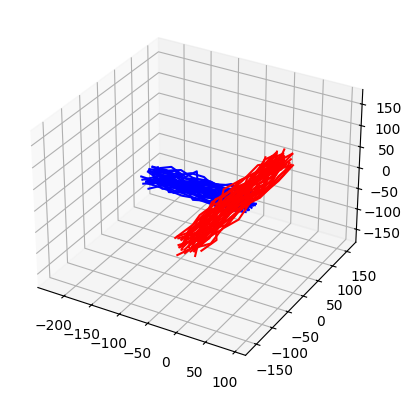

solved: 666, 685/0


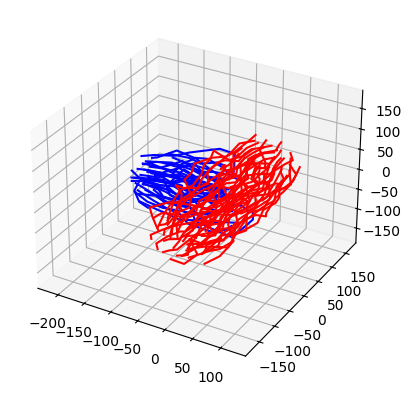

In [18]:
# run solver
solver.fiber_bundles = fiber_bundles
solver.obj_min_radius = 10
solver.obj_mean_length = 30
solver.apply_boundary_conditions(n_max=10)
print(fiber_bundles[0][0].shape)
print(solver.fiber_bundles[0][0].shape)

fbs = solver.fiber_bundles
for i, fb in enumerate(fbs):
    for j, _ in enumerate(fb):
        fbs[i][j][:,:3] += np.random.uniform(-10,10,(fbs[i][j].shape[0],3))
        fbs[i][j][:,3] *= np.random.uniform(0.5,2,(fbs[i][j].shape[0]))
plot_fiber_bundles(fbs, ['b', 'r'])
plt.show()

N = 1000
solver.fiber_bundles = fbs
for i in range(N):
    solved = solver.step()
    if solved:
        break
    print(f'{i/N*100:.2f}%', end='\r')
print(f'solved: {i}, {solver.num_obj}/{solver.num_col_obj}')

plot_fiber_bundles(solver.fiber_bundles, ['b', 'r'])
plt.show()


## Orientation histogram

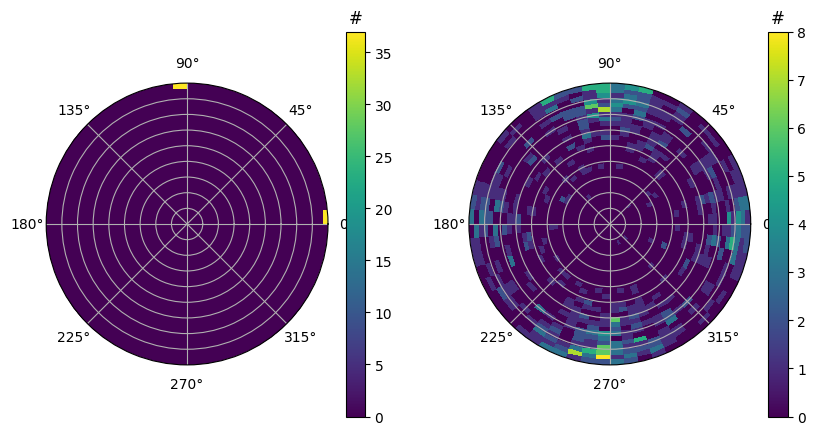

In [19]:
import fastpli.analysis

_, axs = plt.subplots(1,2, subplot_kw=dict(projection='polar'), figsize=(10,5))


pcs=[None, None]
phi, theta = fastpli.analysis.orientation.fiber_bundles(fiber_bundles)
_, _, _, pcs[0] = fastpli.analysis.orientation.histogram(phi,
                                                     theta,
                                                     ax=axs[0],
                                                     n_phi=60,
                                                     n_theta=30,
                                                     weight_area=False)

phi, theta = fastpli.analysis.orientation.fiber_bundles(solver.fiber_bundles)
_, _, _, pcs[1] = fastpli.analysis.orientation.histogram(phi,
                                                     theta,
                                                     ax=axs[1],
                                                     n_phi=60,
                                                     n_theta=30,
                                                     weight_area=False)                                                     

for ax, pc in zip(axs, pcs):
    cbar = plt.colorbar(pc, ax=ax)
    cbar.ax.set_title('#')
    ax.set_rmax(90)
    ax.set_rticks(range(0, 90, 10))
    ax.set_rlabel_position(22.5)
    ax.set_yticklabels([])
    ax.grid(True)

plt.show()